#  군집화 실습 : 고객 세그멘테이션

### 고객 세그멘테이션(Customer Segmentation)
- 비즈니스 상품 판매를 위한 고객 분류
- 매출 발생을 위한 고객 선정 기준 결정
- 고객 세그멘테이션의 주요 목표 : **`타깃 마케팅`**
    - 고객을 여러 특성에 맞게 세분화하고, 고객 유형에 따라 맞춤형 마케팅이나 서비스를 제공
    

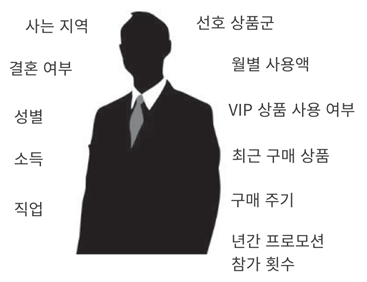

### 고객 세그멘테이션을 위한 고객 군집화 기준
- RFM 기법
    - Recency(R) : 가장 최근 상품 구입 일에서 오늘까지의 기간
    - Frequency(F) : 상품 구매 횟수
    - Monetary Value(M) : 총 구매 금액

## 예제 데이터 : Online Retail Data Set
https://archive.ics.uci.edu/ml/datasets/online+retail


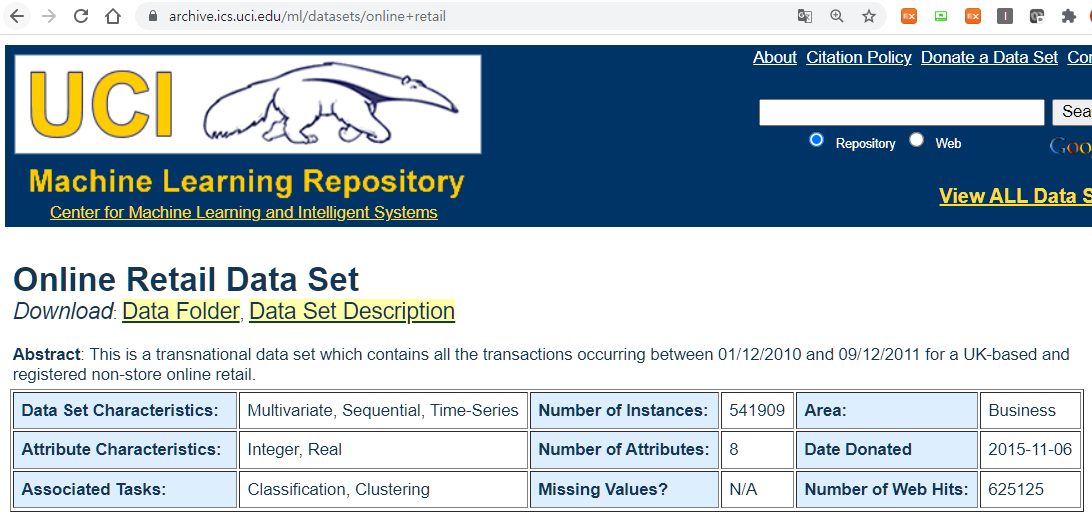



[참고] https://archive.ics.uci.edu/ml/datasets/Online+Retail+II
- 2019년 게시한 데이터세트로 Null 값이 없음

### 데이터 셋 로딩과 데이터 클린징

In [2]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='data/Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**변수**
- InvoiceNo    : 주문번호 'C'로 시작하는 것은 취소 주문      
- StockCode    : 제품 코드(Item Code)
- Description  : 제품 설명        
- Quantity     : 주문 제품 건수         
- InvoiceDate  : 주문 일자
- UnitPrice    : 제품 단가       
- CustomerID   : 고객 번호       
- Country      : 주문고객의국적

**데이터 개수 : 541909**
- CustomerID : Null 값이 13만5천 건

**데이터세트 전체 건수, 컬럼타입, Null개수 확인**

In [6]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [5]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


### RFM 기반 데이터 가공

**주문금액 변수 sale_amount 추가**

: 'Quantity' * 'UnitPrice'

In [8]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']

**CustomerID 자료형을 정수형으로 변환**

In [8]:
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

**Top5 주문건수와 주문금액을 가진 고객 출력**

In [9]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14911    5675
14096    5111
12748    4595
14606    2700
Name: CustomerID, dtype: int64
CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
Name: sale_amount, dtype: float64


**'InvoiceNo'+'StockCode' 기준으로**

In [10]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count()

InvoiceNo  StockCode
536365     21730        1
           22752        1
           71053        1
           84029E       1
           84029G       1
                       ..
581587     22730        1
           22899        1
           23254        1
           23255        1
           23256        1
Name: InvoiceNo, Length: 387841, dtype: int64

In [11]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.0258946320786095

**R, F, M 변수**
- Recency : 가장 최근 상품 구입일에서 오늘까지의 기간
    - 'CustomerID'별로 그룹화하여 'Invoice Date' 중 가장 최근 주문일자를 사용
- Frequency : 고객별 주문건수
    - 'CustomerID'별로 그룹화하여 'InvoiceNo' 개수를 계산
- Monetary : 총구매금액
    - 'CustomerID'별로 그룹화하여 'sale_amount'의 합계를 사용

In [12]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12347,2011-12-07 15:52:00,182,4310.00
2,12348,2011-09-25 13:13:00,31,1797.24


**Recency변수 가공**
- 오늘 날짜를 기준으로 최근 주문 일자를 뺌
- 오늘 날짜 : 2011.12.10
    - 온라인 판매 데이터가 2010.12.01~2011.12.09까지의 데이터

- 2011.12.10에서 최근주문일자를 빼고 일자 데이터(days)만 추출

In [13]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,3,182,4310.00
2,12348,76,31,1797.24


### RFM 기반 고객 세그먼테이션

**R,F,M 변수 히스토그램**

(array([4.303e+03, 1.800e+01, 9.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([3.75000000e+00, 2.80239770e+04, 5.60442040e+04, 8.40644310e+04,
        1.12084658e+05, 1.40104885e+05, 1.68125112e+05, 1.96145339e+05,
        2.24165566e+05, 2.52185793e+05, 2.80206020e+05]),
 <BarContainer object of 10 artists>)

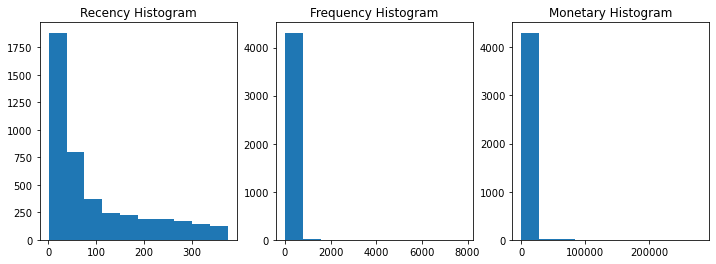

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

**R, F, M 변수 기술통계량**

In [10]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Frequency,Monetary
count,3920.000000,3920.000000
mean,90.388010,1864.385601
std,217.808385,7482.817477
min,1.000000,3.750000
25%,17.000000,300.280000
50%,41.000000,652.280000
75%,99.250000,1576.585000
max,7847.000000,259657.300000


**R, M, F 변수의 표준화**

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

In [33]:
features = ['Recency','Frequency','Monetary']
X_features_scaledDF = pd.DataFrame(data=np.reshape(X_features_scaled, (-1,3)), columns=features)
X_features_scaledDF[features].describe()

,Recency,Frequency,Monetary
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,-2.700058e-17,-3.464648e-18,-1.611077e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.205880e-01,-3.965777e-01,-2.281344e-01
25%,-7.505892e-01,-3.266350e-01,-1.943495e-01
50%,-4.205916e-01,-2.217210e-01,-1.535104e-01
75%,4.969016e-01,3.619268e-02,-4.367134e-02
max,2.809385e+00,3.390157e+01,3.094634e+01


**K-평균 군집분석**

In [16]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.602


In [17]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [35]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

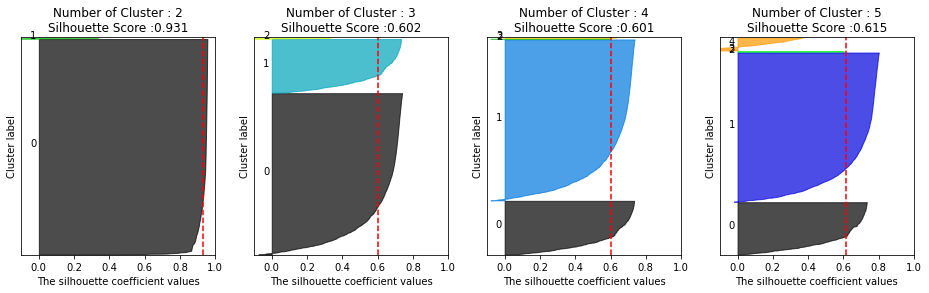

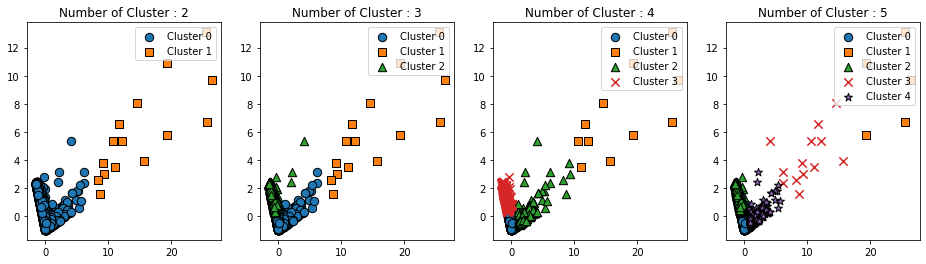

In [36]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

**R, M, F 데이터의 로그변환**

In [37]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))


실루엣 스코어는 : 0.304


In [41]:
features = ['Recency','Frequency','Monetary']
cust_scaledDF = pd.DataFrame(data=np.reshape(X_features_scaled, (-1,3)), columns=features)
cust_scaledDF[features].describe()

,Recency,Frequency,Monetary
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,8.792465e-17,-1.151940e-16,4.100250e-16
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-2.421013e+00,-2.434387e+00,-4.004574e+00
25%,-6.984060e-01,-6.771919e-01,-6.856676e-01
50%,7.196470e-02,4.210882e-04,-6.218718e-02
75%,8.500044e-01,7.021485e-01,6.541861e-01
max,1.583686e+00,4.183306e+00,4.731591e+00


(array([   4.,   26.,  268., 1123., 1435., 1013.,  367.,   71.,   24.,
           7.]),
 array([-4.00457427, -3.13095777, -2.25734126, -1.38372476, -0.51010825,
         0.36350825,  1.23712476,  2.11074126,  2.98435777,  3.85797427,
         4.73159078]),
 <BarContainer object of 10 artists>)

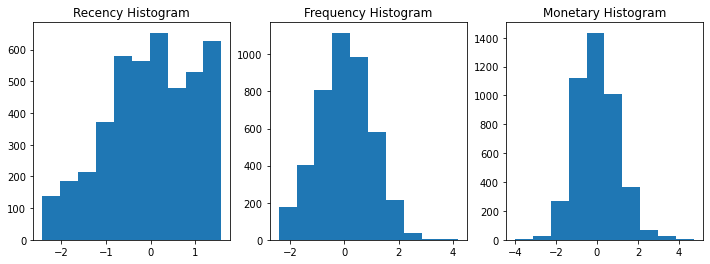

In [42]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_scaledDF['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_scaledDF['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_scaledDF['Monetary'])

**로그변환데이터로 K-평균 군집화 결과: 실루엣 시각화**

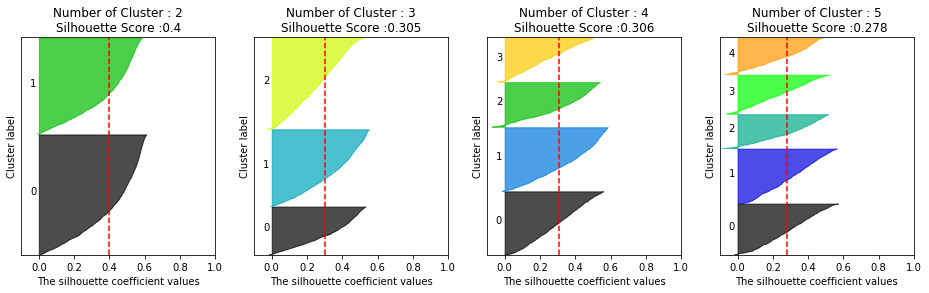

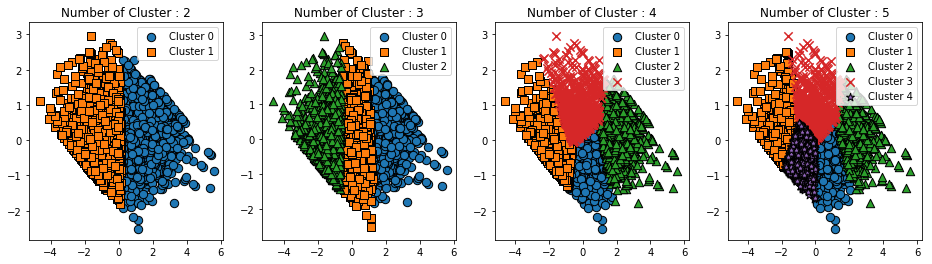

In [20]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)